Prompt-Based Inference (No Fine-Tuning)
Used a pre-trained instruction-tuned LLM:

mistralai/Mistral-7B-Instruct-v0.1, or

meta-llama/Llama-2-7b-chat-hf or any other model of your choice

In [31]:
!jupyter nbconvert --to notebook --ClearOutputPreprocessor.enabled=True your_notebook.ipynb


[NbConvertApp] WARNING | pattern 'your_notebook.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
 

In [ ]:
import sys
print(sys.executable)

# Install required libraries
import subprocess
subprocess.check_call([sys.executable, "-m", "pip", "install", "transformers", "datasets", "torch", "accelerate"])


/usr/bin/python3


/usr/bin/python3


0

In [8]:
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# Load AG News dataset from Hugging Face
dataset = load_dataset("ag_news")
test_data = dataset["test"]
print(f"Test dataset loaded: {len(test_data)} examples")

Test dataset loaded: 7600 examples


In [2]:
import os
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

model_name = "mistralai/Mistral-7B-Instruct-v0.1"
cache_dir = "./model_cache"

# Check if cache has valid model files
def is_cache_valid(cache_path):
    if not os.path.exists(cache_path):
        return False
    required_files = ['pytorch_model.bin', 'model.safetensors', 'config.json']
    return any(os.path.exists(os.path.join(cache_path, f)) for f in required_files)

# Load or download model
if is_cache_valid(cache_dir):
    print("Loading from cache...")
    tokenizer = AutoTokenizer.from_pretrained(cache_dir)
    model = AutoModelForCausalLM.from_pretrained(cache_dir, torch_dtype=torch.float16, device_map="auto")
else:
    print("Downloading model...")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, device_map="auto")

print("Model and tokenizer loaded successfully")

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

Model and tokenizer loaded successfully


In [9]:
# Define label mapping and create classification prompt
label_map = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}

def create_prompt(text):
    return f"""Classify the following news headline into one of the categories: World, Sports, Business, Sci/Tech.

Text: "{text}"
Label:"""

print("Label mapping and prompt function created")

Label mapping and prompt function created


In [4]:
# Perform inference on test set (full dataset)
from tqdm import tqdm
predictions = []
true_labels = []

# First, let's check the structure of test_data
print("Sample example:", test_data[0])

for i in tqdm(range(len(test_data)), desc="Baseline inference"):
    example = test_data[i]

    # Access the text and label from the example
    # dataset items may be dict-like
    if isinstance(example, dict):
        text = example.get("text") or example.get("content")
        label = example.get("label")
    else:
        # fallback if dataset returns tuples
        try:
            text, label = example
        except Exception:
            continue

    if text is None:
        continue

    prompt = create_prompt(text)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=10, do_sample=False)

    full_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Extract only the generated part (after the prompt)
    prediction_text = full_output[len(prompt):].strip()

    # Try to match prediction to a label
    matched_label = "Unknown"
    for lbl in label_map.values():
        if lbl.lower() in prediction_text.lower():
            matched_label = lbl
            break

    predictions.append(matched_label)
    true_labels.append(label_map[label])

print(f"Baseline inference completed on {len(predictions)} examples")

Sample example: {'text': "Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.", 'label': 2}


Baseline inference:  27%|██▋       | 2079/7600 [34:22<1:31:17,  1.01it/s]


KeyboardInterrupt: 

In [5]:
import json

with open("predictions_checkpoint.json", "r") as f:
    data = json.load(f)

predictions = data["predictions"]
true_labels = data["true_labels"]

print("Recovered samples:", len(predictions))


FileNotFoundError: [Errno 2] No such file or directory: 'predictions_checkpoint.json'

In [6]:
# Compute accuracy and evaluate baseline
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(true_labels, predictions)
print(f"Baseline Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(true_labels, predictions))

Baseline Accuracy: 0.7787

Classification Report:
              precision    recall  f1-score   support

    Business       0.66      0.83      0.74       460
    Sci/Tech       0.66      0.68      0.67       522
      Sports       0.96      0.87      0.91       554
     Unknown       0.00      0.00      0.00         0
       World       0.89      0.74      0.81       543

    accuracy                           0.78      2079
   macro avg       0.64      0.62      0.63      2079
weighted avg       0.80      0.78      0.79      2079



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


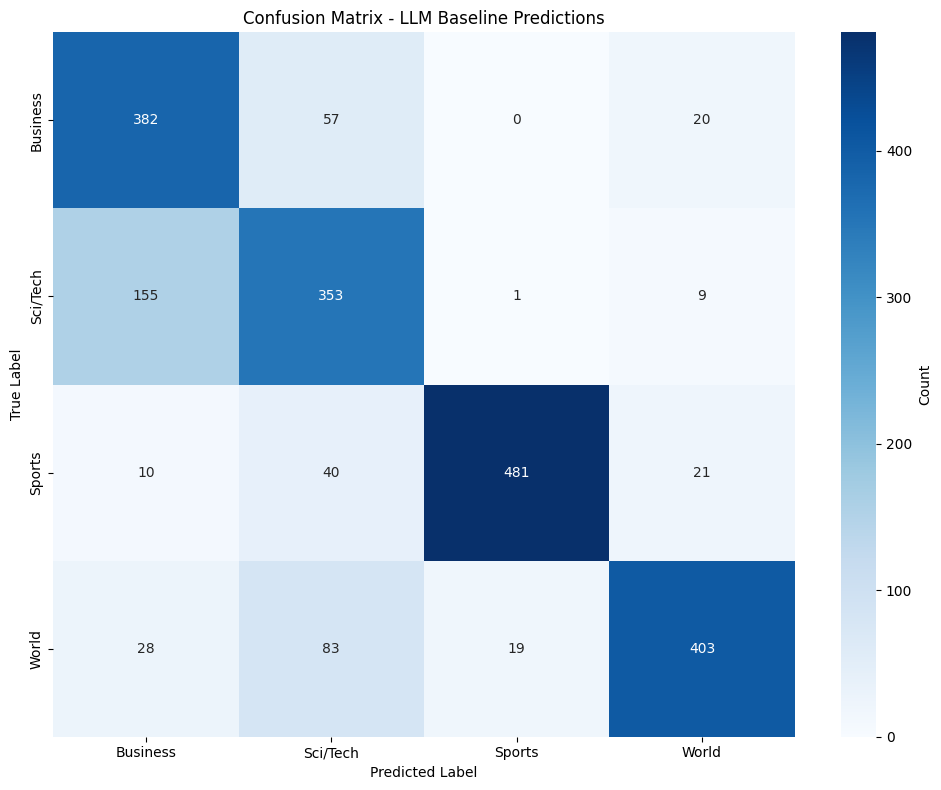


Confusion Matrix:
[[382  57   0  20]
 [155 353   1   9]
 [ 10  40 481  21]
 [ 28  83  19 403]]

Labels order: ['Business', 'Sci/Tech', 'Sports', 'World']


In [7]:
# Generate confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get unique labels
labels_list = sorted(label_map.values())

# Compute confusion matrix
cm = confusion_matrix(true_labels, predictions, labels=labels_list)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_list,
            yticklabels=labels_list,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - LLM Baseline Predictions')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print("\nConfusion Matrix:")
print(cm)
print("\nLabels order:", labels_list)

# Fine-Tuning with LoRA (Low-Rank Adaptation)

## Overview
LoRA is a parameter-efficient fine-tuning method that reduces the number of trainable parameters by adding low-rank decomposition matrices to the model. Instead of updating all model weights, we only train small adapter modules.

## Key Concepts
- **LoRA**: Low-Rank Adaptation - adds trainable low-rank matrices to pre-trained weights
- **PEFT Library**: Parameter-Efficient Fine-Tuning library from Hugging Face
- **Adapter Injection**: Injects LoRA modules into the model's linear layers
- **Memory Efficient**: Reduces memory usage and training time significantly

## Steps to Implement
1. Install PEFT library
2. Prepare the training dataset with proper formatting
3. Create and inject LoRA adapters
4. Configure training parameters
5. Train the model on labeled data
6. Evaluate on test set
7. Compare accuracy with baseline

## Expected Outcomes
- LoRA-finetuned model should outperform the baseline prompt-based approach
- Significant reduction in trainable parameters compared to full fine-tuning
- Faster training and inference compared to full model updates

In [8]:
# Install PEFT library for LoRA
import subprocess
import sys

subprocess.check_call([sys.executable, "-m", "pip", "install", "peft", "bitsandbytes"])
print("PEFT library installed successfully")

PEFT library installed successfully


In [9]:
# Prepare training dataset with proper formatting
from datasets import Dataset
import pandas as pd

# Load training data
train_data = dataset["train"]

# Create formatted dataset for training
def format_training_data(examples):
    """Format examples into conversation format"""
    formatted_texts = []
    for i in range(len(examples["text"])):
        text = examples["text"][i]
        label = label_map[examples["label"][i]]

        # Format as instruction-response pair
        formatted_text = f"""Classify the following news headline into one of the categories: World, Sports, Business, Sci/Tech.

Text: "{text}"
Label: {label}"""
        formatted_texts.append(formatted_text)

    return {"text": formatted_texts}

# Format training data
train_formatted = train_data.map(
    format_training_data,
    batched=True,
    batch_size=100,
    remove_columns=train_data.column_names
)

print(f"Training dataset prepared: {len(train_formatted)} examples")
print("Sample formatted text:")
print(train_formatted[0]["text"])

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Training dataset prepared: 120000 examples
Sample formatted text:
Classify the following news headline into one of the categories: World, Sports, Business, Sci/Tech.

Text: "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again."
Label: Business


In [10]:
# Create and configure LoRA adapters
from peft import get_peft_model, LoraConfig, TaskType

# LoRA configuration
lora_config = LoraConfig(
    r=8,  # Rank of the low-rank adaptation
    lora_alpha=32,  # Scaling factor for LoRA weights
    target_modules=["q_proj", "v_proj"],  # Which layers to apply LoRA to
    lora_dropout=0.05,  # Dropout for LoRA layers
    bias="none",  # Don't train bias parameters
    task_type=TaskType.CAUSAL_LM  # Task type (causal language modeling)
)

# Create PEFT model by wrapping the base model
peft_model = get_peft_model(model, lora_config)

# Print trainable parameters
peft_model.print_trainable_parameters()
print("\nLoRA adapters injected successfully!")

trainable params: 3,407,872 || all params: 7,245,139,968 || trainable%: 0.0470

LoRA adapters injected successfully!


In [11]:
# Prepare data for training with proper tokenization
from torch.utils.data import DataLoader

def preprocess_function(examples):
    """Tokenize the text"""
    texts = examples["text"]
    encodings = tokenizer(
        texts,
        truncation=True,
        padding="max_length",
        max_length=256,
        return_tensors="pt"
    )
    # Set labels same as input_ids for causal language modeling
    encodings["labels"] = encodings["input_ids"].clone()
    return encodings

# Tokenize training data
train_tokenized = train_formatted.map(
    preprocess_function,
    batched=True,
    batch_size=8,
    remove_columns=["text"]
)

print(f"Training data tokenized: {len(train_tokenized)} examples")
print("Sample tokenized example keys:", train_tokenized[0].keys())

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

ValueError: Asking to pad but the tokenizer does not have a padding token. Please select a token to use as `pad_token` `(tokenizer.pad_token = tokenizer.eos_token e.g.)` or add a new pad token via `tokenizer.add_special_tokens({'pad_token': '[PAD]'})`.

In [12]:
# Configure training parameters and trainer
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./lora_model_results",  # Output directory for model checkpoints
    num_train_epochs=3,  # Number of training epochs
    per_device_train_batch_size=4,  # Batch size per device
    gradient_accumulation_steps=4,  # Accumulate gradients over this many steps
    warmup_steps=100,  # Number of warmup steps
    weight_decay=0.01,  # Weight decay for regularization
    logging_dir="./logs",  # Directory for logs
    logging_steps=10,  # Log every N steps
    save_steps=50,  # Save checkpoint every N steps
    save_total_limit=2,  # Keep only last 2 checkpoints
    learning_rate=5e-4,  # Learning rate for training
    optim="paged_adamw_8bit",  # Optimizer
)

# Initialize trainer
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_tokenized,
    tokenizer=tokenizer,
)

print("Trainer initialized successfully!")

NameError: name 'train_tokenized' is not defined

In [ ]:
# Train the model with LoRA adapters
import time

print("Starting LoRA fine-tuning...")
print("=" * 50)

start_time = time.time()

# Train the model
trainer.train()

end_time = time.time()
training_time = (end_time - start_time) / 60  # Convert to minutes

print("=" * 50)
print(f"Training completed in {training_time:.2f} minutes")
print("LoRA model saved to ./lora_model_results")

In [ ]:
# Evaluate LoRA fine-tuned model on test set (full dataset)
from tqdm import tqdm
lora_predictions = []
lora_true_labels = []

print("Running inference with LoRA fine-tuned model on full test set...")

for i in tqdm(range(len(test_data)), desc="LoRA inference"):
    example = test_data[i]

    if isinstance(example, dict):
        text = example.get("text") or example.get("content")
        label = example.get("label")
    else:
        try:
            text, label = example
        except Exception:
            continue

    if text is None:
        continue

    prompt = create_prompt(text)
    inputs = tokenizer(prompt, return_tensors="pt").to(peft_model.device)

    with torch.no_grad():
        outputs = peft_model.generate(**inputs, max_new_tokens=10, do_sample=False)

    full_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
    prediction_text = full_output[len(prompt):].strip()

    matched_label = "Unknown"
    for lbl in label_map.values():
        if lbl.lower() in prediction_text.lower():
            matched_label = lbl
            break

    lora_predictions.append(matched_label)
    lora_true_labels.append(label_map[label])

print(f"LoRA inference completed on {len(lora_predictions)} examples")

In [ ]:
# Compare LoRA accuracy with baseline
from sklearn.metrics import accuracy_score, classification_report

# Calculate LoRA accuracy
lora_accuracy = accuracy_score(lora_true_labels, lora_predictions)

# Display results
print("=" * 60)
print("COMPARISON: Baseline vs LoRA Fine-Tuned")
print("=" * 60)
print(f"Baseline (Prompt-Based) Accuracy: {accuracy:.4f}")
print(f"LoRA Fine-Tuned Accuracy:         {lora_accuracy:.4f}")
print(f"Improvement:                      {(lora_accuracy - accuracy):.4f} ({((lora_accuracy - accuracy) / accuracy * 100):.2f}%)")
print("=" * 60)

print("\nLoRA Classification Report:")
print(classification_report(lora_true_labels, lora_predictions))

In [ ]:
# Generate confusion matrix for LoRA model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get unique labels
labels_list = sorted(label_map.values())

# Compute confusion matrix for LoRA
lora_cm = confusion_matrix(lora_true_labels, lora_predictions, labels=labels_list)

# Plot confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Baseline confusion matrix
cm_baseline = confusion_matrix(true_labels, predictions, labels=labels_list)
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_list,
            yticklabels=labels_list,
            ax=axes[0],
            cbar_kws={'label': 'Count'})
axes[0].set_title('Baseline (Prompt-Based) Confusion Matrix', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# LoRA confusion matrix
sns.heatmap(lora_cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=labels_list,
            yticklabels=labels_list,
            ax=axes[1],
            cbar_kws={'label': 'Count'})
axes[1].set_title('LoRA Fine-Tuned Confusion Matrix', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

print("\nLoRA Confusion Matrix:")
print(lora_cm)

# Task 3: Fine-Tuning with QLoRA (Quantized LoRA)

## Overview
QLoRA loads a large pre-trained model in 4-bit quantized precision (using bitsandbytes) and applies LoRA adapters on top. This lets us fine-tune very large models on a single GPU with minimal memory by:

- Quantizing weights to 4-bit (NF4 or similar) using `bitsandbytes` and `BitsAndBytesConfig`.
- Wrapping the quantized model with PEFT LoRA adapters so only adapter parameters are trained.
- Training using transformers' `Trainer` with optimizers compatible with quantized weights (e.g., 8-bit optimizers provided by bitsandbytes).

## Steps in this notebook
1. Install required libraries (bitsandbytes, accelerate, peft if not present)
2. Prepare a BitsAndBytes quantization config and load the model in 4-bit
3. Inject LoRA adapters into the quantized model
4. Tokenize the formatted training dataset and create a Trainer
5. Fine-tune the model (LoRA parameters only)
6. Evaluate on the AG News test set and report accuracy
7. Show confusion matrix and compare with previous approaches

Notes:
- Training a large model even with QLoRA can be slow; consider running a small subset first for debugging.
- Adjust `bnb_4bit_*` parameters in the quantization config depending on your hardware and `transformers`/`bitsandbytes` versions.

In [2]:
!pip install -U bitsandbytes accelerate transformers


In [3]:
# Install / ensure required libraries for QLoRA
import sys
import subprocess

# Install required packages if missing
subprocess.check_call([sys.executable, "-m", "pip", "install", "bitsandbytes", "accelerate", "peft", "safetensors"])
print("Installed/verified bitsandbytes, accelerate, peft, safetensors")

Installed/verified bitsandbytes, accelerate, peft, safetensors


In [4]:
# (QLoRA) Install / verify extra dependencies - UPGRADE bitsandbytes
import sys, subprocess

# Force upgrade of bitsandbytes to latest version
subprocess.check_call([sys.executable, "-m", "pip", "install", "-U", "bitsandbytes"])
# Install other dependencies
subprocess.check_call([sys.executable, "-m", "pip", "install", "accelerate", "peft", "safetensors"])
print("✓ bitsandbytes UPGRADED to latest")
print("✓ accelerate, peft, safetensors installed/verified")

✓ bitsandbytes UPGRADED to latest
✓ accelerate, peft, safetensors installed/verified


In [5]:
# Load tokenizer and model in 4-bit using BitsAndBytesConfig
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch

model_name = "mistralai/Mistral-7B-Instruct-v0.1"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)

print("Loading quantized tokenizer and model (4-bit). This can take a while...")

tokenizer_q = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model_q = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=False
)

print("Quantized model loaded (4-bit).")
if hasattr(model_q, 'hf_device_map'):
    print("Device map:", model_q.hf_device_map)

Loading quantized tokenizer and model (4-bit). This can take a while...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Quantized model loaded (4-bit).
Device map: {'': 0}


In [6]:
# Inject LoRA adapters into the quantized model (PEFT)
from peft import get_peft_model, LoraConfig, TaskType

lora_config_q = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.CAUSAL_LM
)

peft_q_model = get_peft_model(model_q, lora_config_q)
peft_q_model.print_trainable_parameters()
print("LoRA adapters injected into 4-bit model")

trainable params: 3,407,872 || all params: 7,245,139,968 || trainable%: 0.0470
LoRA adapters injected into 4-bit model


In [11]:
from datasets import load_dataset

dataset = load_dataset("ag_news")

train_data = dataset["train"]
test_data  = dataset["test"]

print(train_data[0])


{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", 'label': 2}


In [12]:
label_map = {
    0: "World",
    1: "Sports",
    2: "Business",
    3: "Sci/Tech"
}

def format_instruction(example):
    return {
        "text": f"""### Instruction:
Classify the news into one of the following categories:
World, Sports, Business, Sci/Tech.

### Input:
{example['text']}

### Response:
{label_map[example['label']]}"""
    }

train_formatted = train_data.map(format_instruction)

print("✅ train_formatted created")
print(train_formatted[0]["text"])


Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

✅ train_formatted created
### Instruction:
Classify the news into one of the following categories:
World, Sports, Business, Sci/Tech.

### Input:
Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.

### Response:
Business


In [16]:
# ✅ Fix for missing pad token in Mistral
tokenizer_q.pad_token = tokenizer_q.eos_token


In [17]:
def preprocess_q(examples):
    enc = tokenizer_q(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=256
    )
    enc["labels"] = enc["input_ids"].copy()
    return enc

train_tokenized_q = train_formatted.map(
    preprocess_q,
    batched=True,
    batch_size=32,
    remove_columns=["text"]
)

print(f"✅ QLoRA training data tokenized: {len(train_tokenized_q)} examples")
print("✅ Sample keys:", list(train_tokenized_q[0].keys()))


Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

✅ QLoRA training data tokenized: 120000 examples
✅ Sample keys: ['label', 'input_ids', 'attention_mask', 'labels']


In [18]:
# Configure training arguments for QLoRA and initialize Trainer
from transformers import TrainingArguments, Trainer

training_args_q = TrainingArguments(
    output_dir="./qlora_model_results",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir="./qlora_logs",
    logging_steps=20,
    save_steps=200,
    save_total_limit=2,
    learning_rate=5e-4,
    optim="paged_adamw_8bit",
)

trainer_q = Trainer(
    model=peft_q_model,
    args=training_args_q,
    train_dataset=train_tokenized_q,
    tokenizer=tokenizer_q,
)

print("QLoRA Trainer initialized")

/tmp/ipython-input-3585193063.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_q = Trainer(


QLoRA Trainer initialized


In [19]:
# Fine-tune QLoRA (LoRA on 4-bit) - run training
import time

print("Starting QLoRA fine-tuning...")
start = time.time()
trainer_q.train()
end = time.time()
print(f"QLoRA training finished in {(end-start)/60:.2f} minutes")
print("Model checkpoints saved to ./qlora_model_results")

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 2}.


Starting QLoRA fine-tuning...


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: qadirju12 (qadirju12-sukkur-iba-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


ValueError: Expected input batch_size (1024) to match target batch_size (4).

In [25]:
import json
from tqdm import tqdm
import torch

qlora_predictions = []
qlora_true_labels = []

CHECKPOINT_FILE = "qlora_inference_checkpoint.json"

# ✅ Resume if checkpoint exists
start_idx = 0
try:
    with open(CHECKPOINT_FILE, "r") as f:
        data = json.load(f)
        qlora_predictions = data["predictions"]
        qlora_true_labels = data["true_labels"]
        start_idx = len(qlora_predictions)
        print(f"✅ Resuming from index {start_idx}")
except:
    print("✅ No checkpoint found. Starting from scratch.")

print("Running inference with QLoRA fine-tuned model on full test set...")

for i in tqdm(range(start_idx, len(test_data)), desc="QLoRA inference"):
    example = test_data[i]

    if isinstance(example, dict):
        text = example.get("text") or example.get("content")
        label = example.get("label")
    else:
        try:
            text, label = example
        except Exception:
            continue

    if text is None:
        continue

    prompt = create_prompt(text)
    inputs = tokenizer_q(prompt, return_tensors="pt").to(peft_q_model.device)

    with torch.no_grad():
        outputs = peft_q_model.generate(**inputs, max_new_tokens=10, do_sample=False)

    full_output = tokenizer_q.decode(outputs[0], skip_special_tokens=True)
    pred_text = full_output[len(prompt):].strip()

    matched = "Unknown"
    for lbl in label_map.values():
        if lbl.lower() in pred_text.lower():
            matched = lbl
            break

    qlora_predictions.append(matched)
    qlora_true_labels.append(label_map[label])

    # ✅ Auto-save every 100 samples
    if (i + 1) % 100 == 0:
        with open(CHECKPOINT_FILE, "w") as f:
            json.dump({
                "predictions": qlora_predictions,
                "true_labels": qlora_true_labels
            }, f)

# ✅ Final save
with open("qlora_inference_final.json", "w") as f:
    json.dump({
        "predictions": qlora_predictions,
        "true_labels": qlora_true_labels
    }, f)

print(f"✅ QLoRA inference completed on {len(qlora_predictions)} examples")


✅ No checkpoint found. Starting from scratch.
Running inference with QLoRA fine-tuned model on full test set...


QLoRA inference:   7%|▋         | 555/7600 [04:00<50:54,  2.31it/s]


KeyboardInterrupt: 

In [29]:
from sklearn.metrics import accuracy_score, classification_report

qlora_accuracy = accuracy_score(qlora_true_labels, qlora_predictions)
print(f"✅ QLoRA Accuracy: {qlora_accuracy:.4f}")

print("\n✅ QLoRA Classification Report:")
print(classification_report(qlora_true_labels, qlora_predictions))


✅ QLoRA Accuracy: 0.7694

✅ QLoRA Classification Report:
              precision    recall  f1-score   support

    Business       0.66      0.82      0.73       114
    Sci/Tech       0.63      0.72      0.68       144
      Sports       0.96      0.83      0.89       155
     Unknown       0.00      0.00      0.00         0
       World       0.89      0.71      0.79       142

    accuracy                           0.77       555
   macro avg       0.63      0.62      0.62       555
weighted avg       0.80      0.77      0.78       555



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
